In [1]:
import numpy as np
import pandas as pd
import joblib
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import Draw
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
import gzip
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Scaffolds import MurckoScaffold

# AiZynthFinder outputs

In [2]:
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64

In [3]:
def mol_display(mol):
    '''function to draw multiple molecules'''
    d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    buffer = BytesIO(d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [5]:
sc = SCScorer()
sc.restore(os.path.join('/home/zumrovad/DP/scscore','models', 'full_reaxys_model_1024bool','model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from /home/zumrovad/DP/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


# 1

In [4]:
data = pd.read_csv('data/output200-0.csv')
data.number_of_steps.value_counts()

1    82
2    58
3    23
5    13
7     9
6     8
4     7
Name: number_of_steps, dtype: int64

<AxesSubplot:>

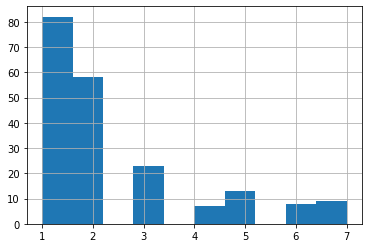

In [9]:
data.number_of_steps.hist() # 1

In [52]:
data_1 = data[data.number_of_steps == 1]
data_4 = data[data.number_of_steps == 4]
data_7 = data[data.number_of_steps == 7]

In [53]:
mol = [Chem.MolFromSmiles(m) for m in data_1.target]
data_1 = data_1.assign(mol=mol)
mol4 = [Chem.MolFromSmiles(m) for m in data_4.target]
data_4 = data_4.assign(mol=mol4)
mol7 = [Chem.MolFromSmiles(m) for m in data_7.target]
data_7 = data_7.assign(mol=mol7)

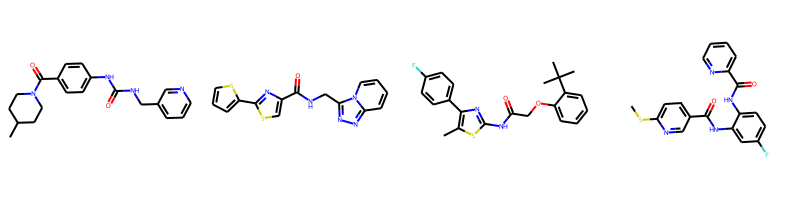

In [40]:
Draw.MolsToGridImage(data_1['mol'], molsPerRow=4, maxMols=4)

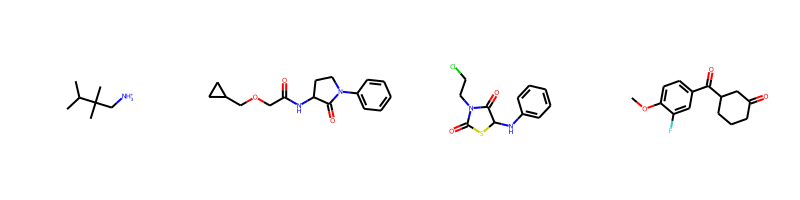

In [41]:
Draw.MolsToGridImage(data_7['mol'], molsPerRow=4, maxMols=4)

In [55]:
frames = [data_1[:3], data_4[:3],data_7[:3]]
result_data = pd.concat(frames)

In [58]:
scscore = [sc.get_score_from_smi(smile)[1] for smile in result_data.target]
syba = [sy.predict(smile) for smile in result_data.target]
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in result_data.target]
result_data = result_data.assign(scscore=scscore, syba=syba, sascore=sascore)

[Text(0.5, 0, 'number_of_steps'), Text(0, 0.5, 'syba')]

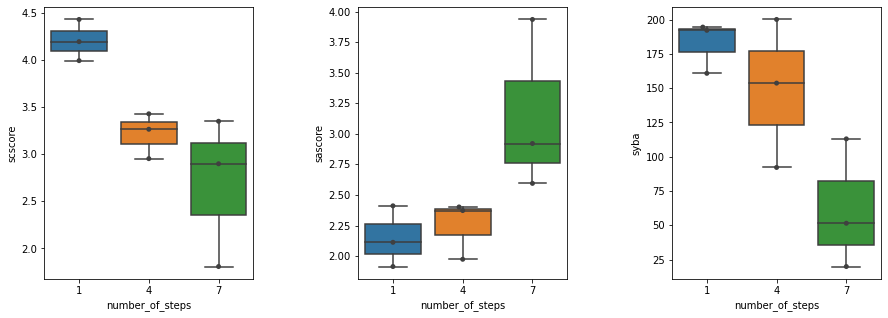

In [254]:
fig, axs = plt.subplots(ncols=3,figsize=(15,5))
plt.subplots_adjust(wspace = 0.5)

sns.boxplot(x='number_of_steps', y='scscore', data=result_data, ax=axs[0])
sns.swarmplot(x='number_of_steps', y='scscore', data=result_data, color=".25",ax=axs[0])
sns.boxplot(x='number_of_steps', y='sascore', data=result_data, ax=axs[1])
sns.swarmplot(x='number_of_steps', y='sascore', data=result_data, color=".25",ax=axs[1])
sns.boxplot(x='number_of_steps', y='syba', data=result_data, ax=axs[2])
sns.swarmplot(x='number_of_steps', y='syba', data=result_data, color=".25",ax=axs[2])

axs[0].set(xlabel="number_of_steps", ylabel = "scscore")
axs[1].set(xlabel="number_of_steps", ylabel = "sascore")
axs[2].set(xlabel="number_of_steps", ylabel = "syba")

In [6]:
scscore = [sc.get_score_from_smi(smile)[1] for smile in data.target]
syba = [sy.predict(smile) for smile in data.target]
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in data.target]
data = data.assign(scscore=scscore, syba=syba, sascore=sascore)

[Text(0.5, 0, 'number_of_steps'), Text(0, 0.5, 'syba')]

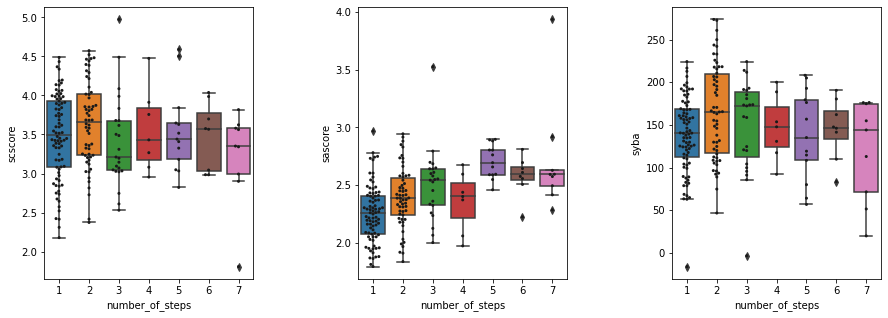

In [265]:
fig, axs = plt.subplots(ncols=3,figsize=(15,5))
plt.subplots_adjust(wspace = 0.5)

sns.boxplot(x='number_of_steps', y='scscore', data=data, ax=axs[0])
sns.swarmplot(x='number_of_steps', y='scscore', data=data, color="0.1",ax=axs[0],size=3)
sns.boxplot(x='number_of_steps', y='sascore', data=data, ax=axs[1])
sns.swarmplot(x='number_of_steps', y='sascore', data=data, color="0.1",ax=axs[1], size=3)
sns.boxplot(x='number_of_steps', y='syba', data=data, ax=axs[2])
sns.swarmplot(x='number_of_steps', y='syba', data=data, color="0.1",ax=axs[2], size=3)

axs[0].set(xlabel="number_of_steps", ylabel = "scscore")
axs[1].set(xlabel="number_of_steps", ylabel = "sascore")
axs[2].set(xlabel="number_of_steps", ylabel = "syba")

### Scaffolds
Analýza scaffoldů skupin

In [33]:
mols = [Chem.MolFromSmiles(smile) for smile in data.target]
data['mol'] = mols
data["scaf1"] = data['mol'].apply(MurckoScaffold.GetScaffoldForMol)
data["scaf2"] = data['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
data["scaf3"] = data['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
data["scaf3_smiles"] = data['scaf3'].apply(Chem.MolToSmiles)

,mol,scaf3,target,number_of_steps
0,,,CC1CCN(C(=O)c2ccc(NC(=O)NCc3cccnc3)cc2)CC1,1
1,,,CCC(C)NC(=O)CSc1nnc(-c2cccc(C)c2)n1CC,2
2,,,CC(Sc1nnc(-c2ccc(C(C)(C)C)cc2)n1N)C(=O)NCc1ccc(F)cc1,5

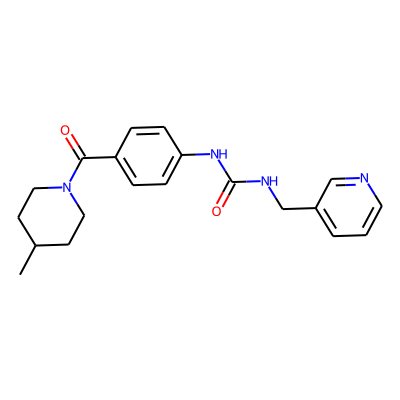
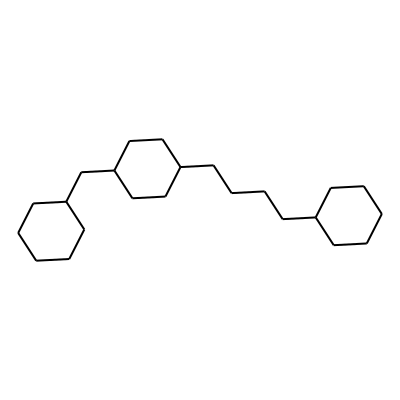
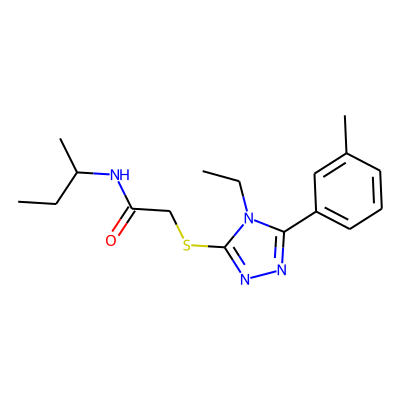
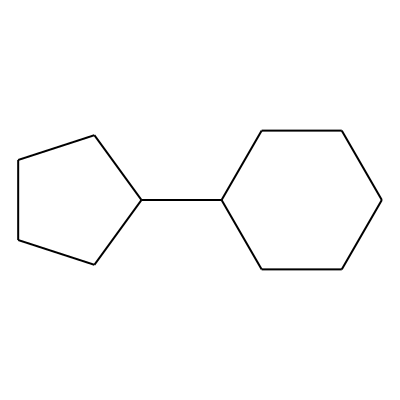
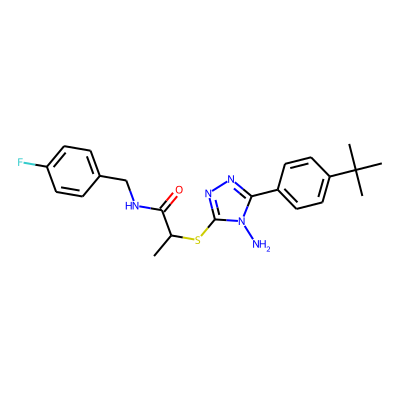
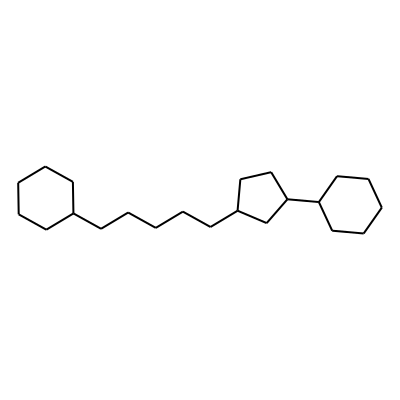

In [39]:
HTML(data[['mol','scaf3','target','number_of_steps']].head(3).to_html(
    formatters={'scaf3': mol_display,'mol': mol_display}, escape=False))

The most common scaffolds

In [36]:
scaf_count = data['scaf3_smiles'].value_counts()
scaf_count_data = pd.DataFrame(scaf_count)
scaf_count_data['scaffold'] = scaf_count_data.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

,scaf3_smiles,scaffold
C1CCC(CCCCCC2CCCCC2)CC1,8,
C1CCCCC1,8,
C1CCC(CC2CCCCC2)CC1,7,
C1CCC(CCC2CCC(C3CCCCC3)C2)CC1,5,
C(CCCCC1CCCCC1)CCCC1CCCCC1,4,

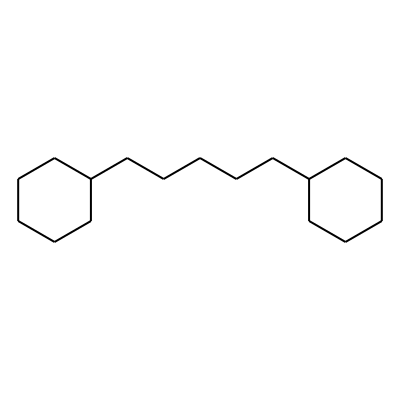
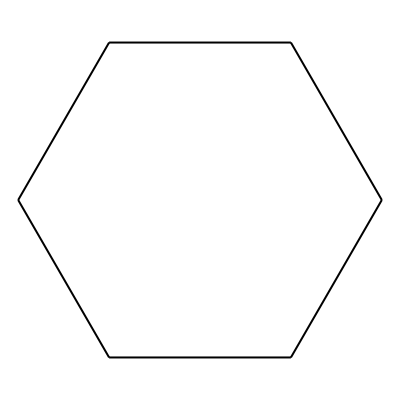
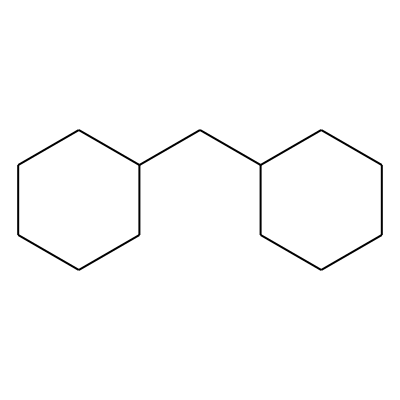
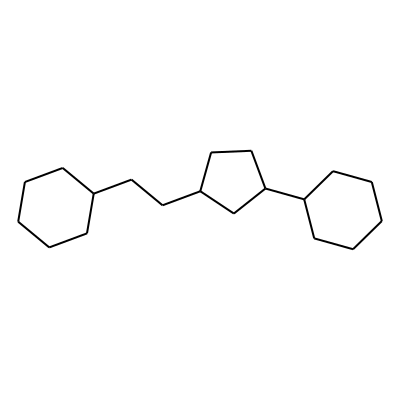
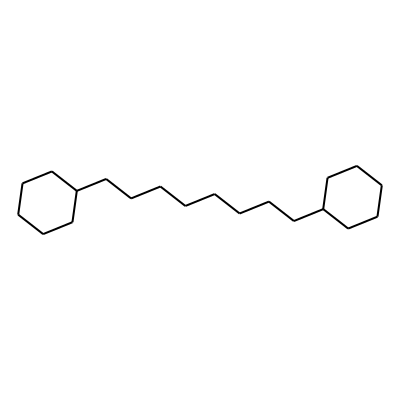

In [38]:
HTML(scaf_count_data.head().to_html(formatters={'scaffold': mol_display}, escape=False))

Group number_of_steps == 1

In [42]:
data_1 = data[data.number_of_steps == 1]
scaf_count_1 = data_1['scaf3_smiles'].value_counts()
scaf_count_data_1 = pd.DataFrame(scaf_count_1)
scaf_count_data_1['scaffold'] = scaf_count_data_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [71]:
len(data_1), len(scaf_count_data_1)

(82, 62)

,scaf3_smiles,scaffold
C1CCC(CCCCCC2CCCCC2)CC1,4,
C1CCC(CCC2CCCC2)CC1,3,
C1CCC(CCCCC2CCC(C3CCCCC3)C2)CC1,3,
C1CCCCC1,3,
C(CCCCC1CCCCC1)CCCC1CCCCC1,3,

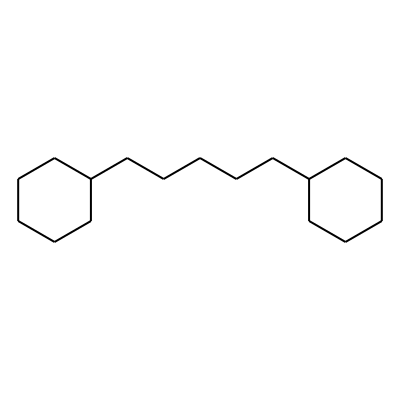
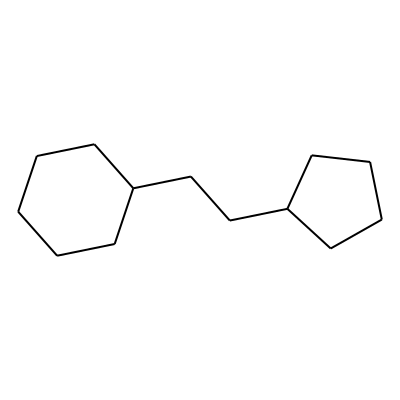
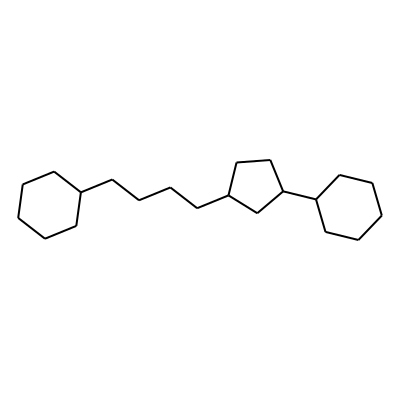
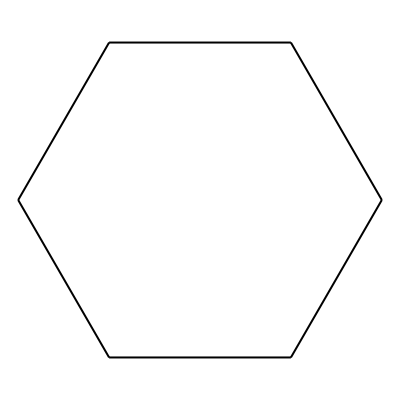
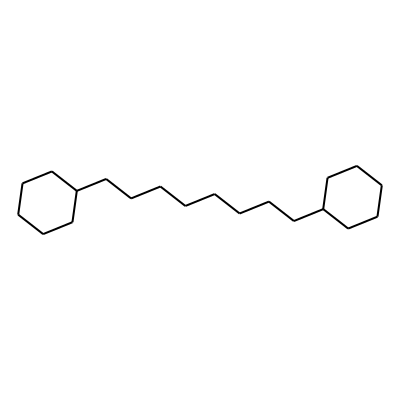

In [43]:
HTML(scaf_count_data_1.head().to_html(formatters={'scaffold': mol_display}, escape=False))

### Fragments

In [ ]:
# Analýza fragmentů 
## Klasifikační model - vstup fingerprint, vystup pocet kroku
### muzu trenovat rovnou na techto datech 
## zpetne se podivan na kterych bitech nejvice zaviselo rozdeleni a co je to za fragment

# 2,3

<AxesSubplot:>

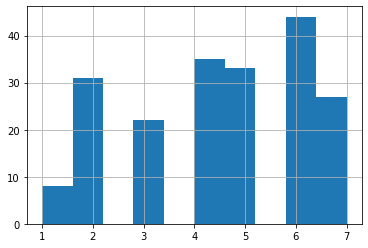

In [47]:
data1 = pd.read_csv('data/output200-1.csv')
data1.number_of_steps.hist() # 2,3

# 4, 5, 6

<AxesSubplot:>

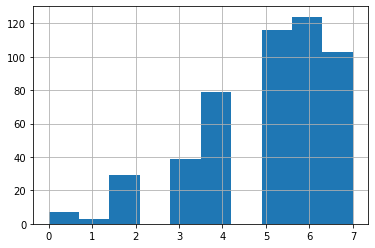

In [48]:
data2 = pd.read_csv('data/output500-2.csv')
data2.number_of_steps.hist() # 4, 5, 6

# 7,8,9,10

<AxesSubplot:>

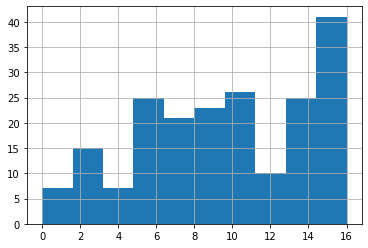

In [49]:
data3 = pd.read_csv('data/output200-3.csv')
data3.number_of_steps.hist() # 7,8,9,10

# 11

<AxesSubplot:>

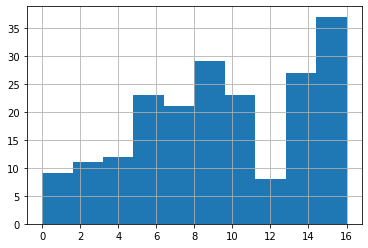

In [73]:
data4 = pd.read_csv('data/output200-4.csv')
data4.number_of_steps.hist() 

### Complicated structures

In [230]:
data_15 = data4[data4.number_of_steps == 15]
data_10 = data4[data4.number_of_steps == 10]
data_7_4 = data4[data4.number_of_steps == 7]

In [231]:
mol15 = [Chem.MolFromSmiles(m) for m in data_15.target]
data_15 = data_15.assign(mol=mol15)
mol10 = [Chem.MolFromSmiles(m) for m in data_10.target]
data_10 = data_10.assign(mol=mol10)
mol74 = [Chem.MolFromSmiles(m) for m in data_7_4.target]
data_7_4 = data_7_4.assign(mol=mol74)

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 4. Change the maxMols value to display more.
  warnings.warn(


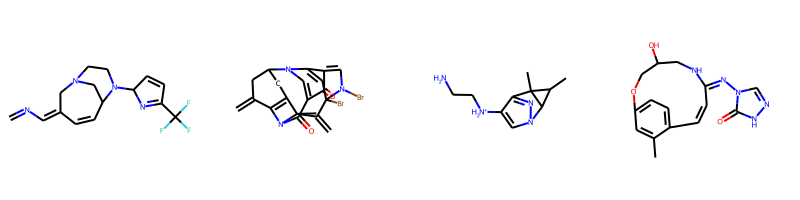

In [232]:
Draw.MolsToGridImage(data_15['mol'], molsPerRow=4, maxMols=4)

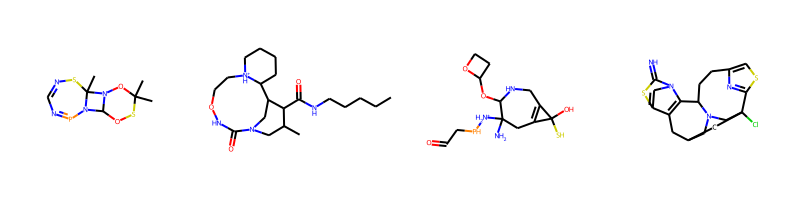

In [203]:
Draw.MolsToGridImage(data_10['mol'], molsPerRow=4, maxMols=4)

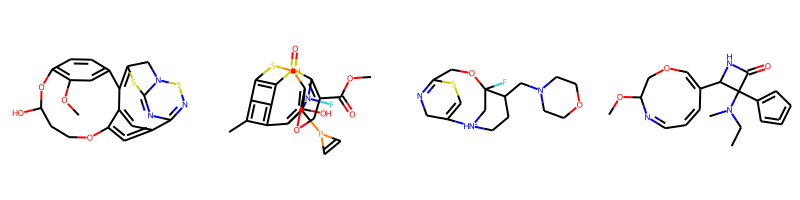

In [204]:
Draw.MolsToGridImage(data_7_4['mol'], molsPerRow=4, maxMols=4)

V Reaxys data nenalezena.

In [ ]:
# Vyhledat v databazich zda to existuje (pouziva se)
# Porovnat pocet kroku s Reaxys
# smazani oblud

# All data without "monsters"

In [88]:
frames = [data, data1, data2, data3]
all_data = pd.concat(frames)
all_data = all_data.reset_index(drop=True)

In [90]:
all_data = all_data[all_data.number_of_steps <= 8]
all_data = all_data[all_data.number_of_steps > 0]

In [91]:
len(all_data)

972

In [92]:
all_data.number_of_steps.value_counts()

6    192
5    171
7    160
4    128
2    127
1     94
3     90
8     10
Name: number_of_steps, dtype: int64

<AxesSubplot:>

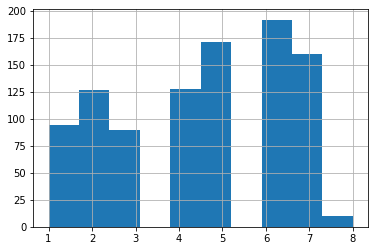

In [93]:
all_data.number_of_steps.hist() 

In [94]:
scsc = [sc.get_score_from_smi(smile)[1] for smile in all_data.target]
syba = [sy.predict(smile) for smile in all_data.target]
sasc = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in all_data.target]
all_data = all_data.assign(scscore=scsc, syba=syba, sascore=sasc)

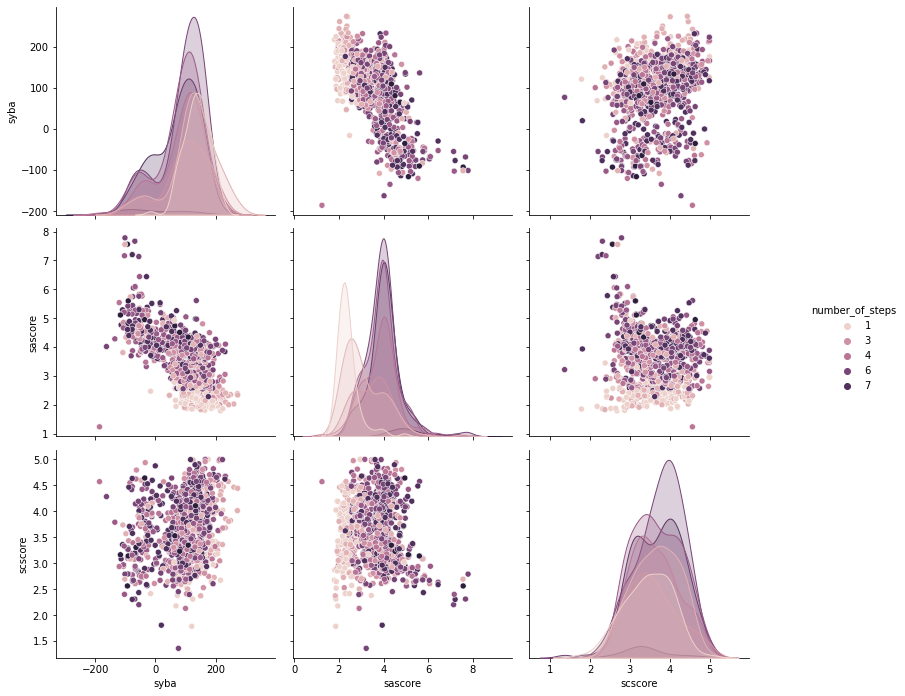

In [95]:
g = sns.pairplot(all_data[['number_of_steps', 'syba', 'sascore', 'scscore']], hue='number_of_steps')
g.fig.set_size_inches(13,10)

In [96]:
all_mols = [Chem.MolFromSmiles(smile) for smile in all_data.target]
all_data['mol'] = all_mols
all_data["scaf1"] = all_data['mol'].apply(MurckoScaffold.GetScaffoldForMol)
all_data["scaf2"] = all_data['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
all_data["scaf3"] = all_data['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
all_data["scaf3_smiles"] = all_data['scaf3'].apply(Chem.MolToSmiles)

Group number_of_steps = 1

In [97]:
alldata_1 = all_data[all_data.number_of_steps == 1]
scaf_count_all1 = alldata_1['scaf3_smiles'].value_counts()
scaf_count_alldata_1 = pd.DataFrame(scaf_count_all1)
scaf_count_alldata_1['scaffold'] = scaf_count_alldata_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [98]:
len(alldata_1),len(scaf_count_alldata_1)

(94, 67)

,scaf3_smiles,scaffold
C1CCCCC1,5,
C1CCC(CCCCCC2CCCCC2)CC1,4,
C1CCC(CCCCC2CCC(C3CCCCC3)C2)CC1,3,
C1CCCC1,3,

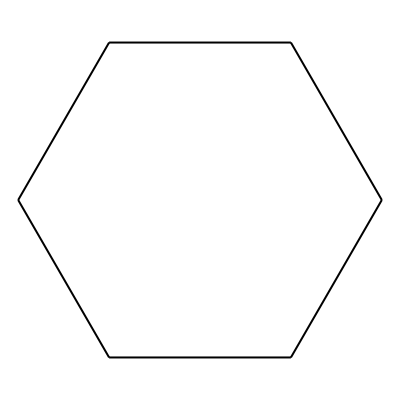
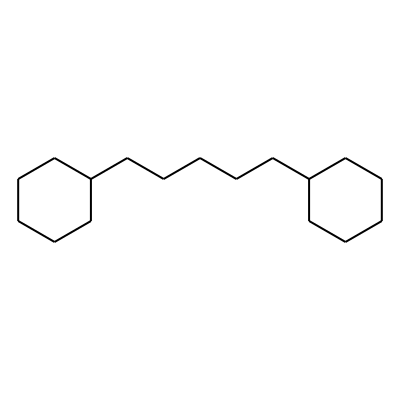
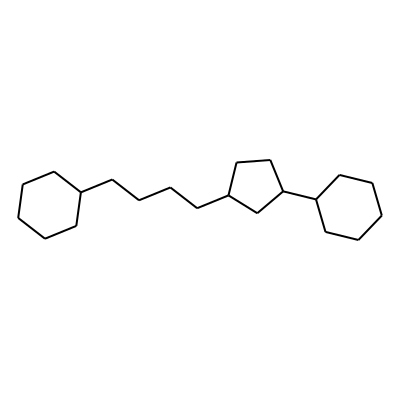
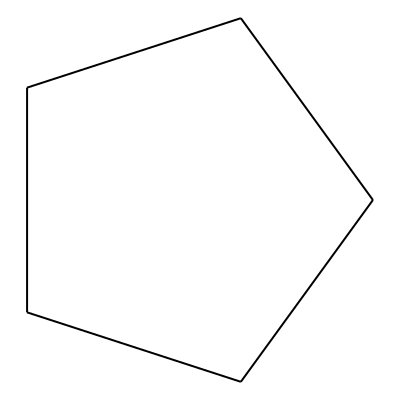

In [99]:
HTML(scaf_count_alldata_1.head(4).to_html(formatters={'scaffold': mol_display}, escape=False))

Group number_of_steps = 6

In [100]:
alldata_6 = all_data[all_data.number_of_steps == 6]
scaf_count_all6 = alldata_6['scaf3_smiles'].value_counts()
scaf_count_alldata_6 = pd.DataFrame(scaf_count_all6)
scaf_count_alldata_6['scaffold'] = scaf_count_alldata_6.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [101]:
len(alldata_6), len(scaf_count_alldata_6)

(192, 153)

In [102]:
scaf_count_alldata_6.head(5)

,scaf3_smiles,scaffold
C1CCCCC1,8,<rdkit.Chem.rdchem.Mol object at 0x7f96f4c079a0>
C1CCC(CCCCCC2CCCCC2)CC1,5,<rdkit.Chem.rdchem.Mol object at 0x7f96f4c078e0>
C1CCC(CCC2CCCC2)CC1,5,<rdkit.Chem.rdchem.Mol object at 0x7f96f4c06ca0>
C1CCC(CC2CCCC2)CC1,5,<rdkit.Chem.rdchem.Mol object at 0x7f96f4c06a00>
C1CCC(CC2CCCCC2)CC1,4,<rdkit.Chem.rdchem.Mol object at 0x7f96f4c04760>


,scaf3_smiles,scaffold
C1CCCCC1,8,
C1CCC(CCCCCC2CCCCC2)CC1,5,
C1CCC(CCC2CCCC2)CC1,5,
C1CCC(CC2CCCC2)CC1,5,

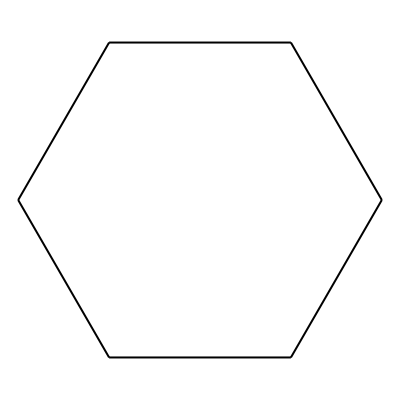
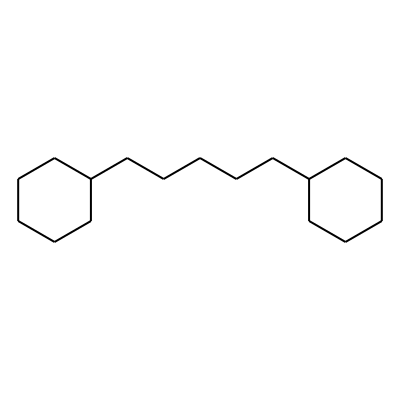
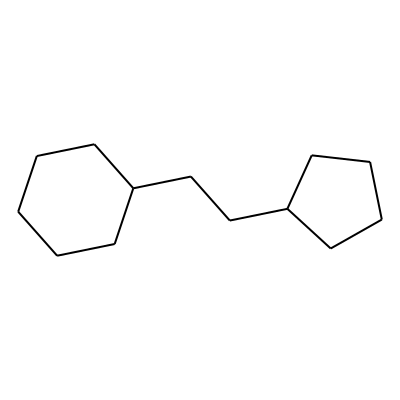
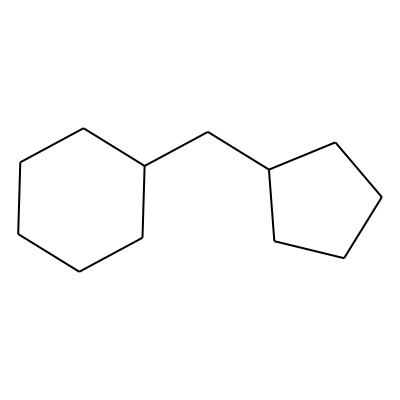

In [103]:
HTML(scaf_count_alldata_6.head(4).to_html(formatters={'scaffold': mol_display}, escape=False))

Group number_of_steps == 2

In [104]:
alldata_2 = all_data[all_data.number_of_steps == 2]
scaf_count_all2 = alldata_2['scaf3_smiles'].value_counts()
scaf_count_alldata_2 = pd.DataFrame(scaf_count_all2)
scaf_count_alldata_2['scaffold'] = scaf_count_alldata_2.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [105]:
len(alldata_2), len(scaf_count_alldata_2)

(127, 98)

In [106]:
scaf_count_alldata_2.head(5)

,scaf3_smiles,scaffold
C1CCCCC1,7,<rdkit.Chem.rdchem.Mol object at 0x7f96f4bf29a0>
C1CCC(CC2CCCCC2)CC1,6,<rdkit.Chem.rdchem.Mol object at 0x7f96f4bdf8e0>
C1CCCC1,5,<rdkit.Chem.rdchem.Mol object at 0x7f96f4bdfdc0>
C1CCC(CCCCCC2CCCCC2)CC1,3,<rdkit.Chem.rdchem.Mol object at 0x7f96f4b67ee0>
C1CCC(CCC2CC3CCCCC3C2)CC1,3,<rdkit.Chem.rdchem.Mol object at 0x7f96f4b673a0>


,scaf3_smiles,scaffold
C1CCCCC1,7,
C1CCC(CC2CCCCC2)CC1,6,
C1CCCC1,5,

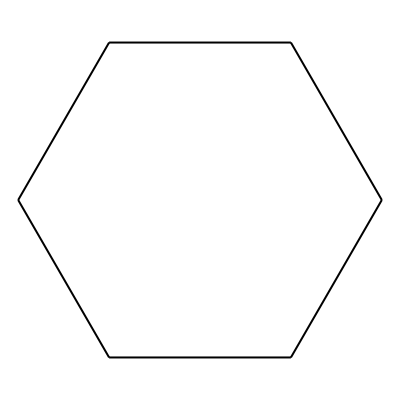
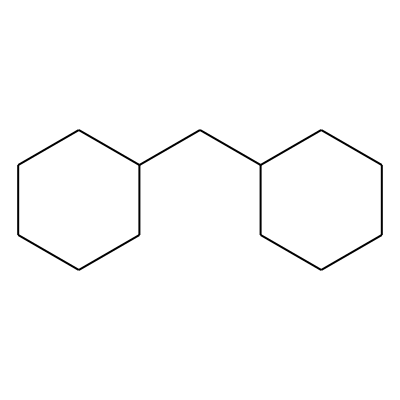
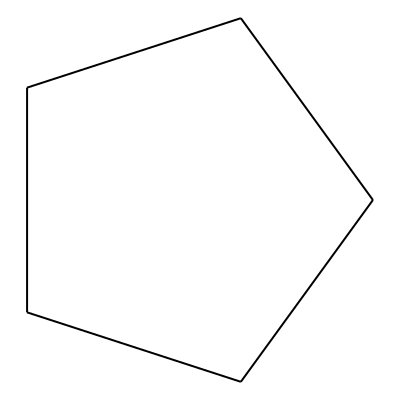

In [107]:
HTML(scaf_count_alldata_2.head(3).to_html(formatters={'scaffold': mol_display}, escape=False))

In [ ]:
# zvazit uplne jina data